# Network design with redundancy
[![electric_grid_with_redundancy.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/military/electric_grid_with_redundancy.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/military/electric_grid_with_redundancy.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/military/electric_grid_with_redundancy.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/military/electric_grid_with_redundancy.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/military/electric_grid_with_redundancy.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/military/electric_grid_with_redundancy.ipynb)](https://colab.ampl.com)

Description: Design of an electricity transportation network provides enough redundancy, so that a break of one component does not prevent any user from receiving electricity. The approach also works for similar distribution networks and can potentially be used in the design of military logistic networks.

Tags: electric-grid, military

Notebook author: Filipe Brandão <<fdabrandao@gmail.com>>

Model author: Filipe Brandão

In [200]:
# Install dependencies
%pip install -q amplpy matplotlib networkx

In [201]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi", "highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Network

In [202]:
# Data typically would come from some source such as csv/excel files, databases, etc.
# In this example the data is in the python dictionaries below
coordinates = {
    1: (300, 100),
    2: (600, 100),
    3: (700, 200),
    4: (900, 700),
    5: (500, 500),
    6: (400, 900),
    7: (150, 100),
    8: (400, 80),
    9: (950, 70),
    10: (30, 120),
    11: (600, 300),
    12: (20, 450),
    13: (300, 500),
    14: (950, 450),
    15: (70, 800),
    16: (350, 750),
    17: (500, 750),
    18: (600, 800),
    19: (600, 900),
    20: (750, 750),
    21: (850, 950),
}
demsup = {
    1: -900,
    2: -500,
    3: -1200,
    4: -450,
    5: -750,
    6: -1200,
    7: 200,
    8: 300,
    9: 200,
    10: 250,
    11: 300,
    12: 250,
    13: 300,
    14: 300,
    15: 250,
    16: 150,
    17: 250,
    18: 300,
    19: 100,
    20: 250,
    21: 250,
}
capacity = 1000

In [203]:
import matplotlib.pyplot as plt


def dist(u, v):
    (x1, y1), (x2, y2) = coordinates[u], coordinates[v]
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5


def draw_network(edges, coordinates, balance):
    xl, yl = zip(*[coordinates[u] for u in [u for u in balance if balance[u] < 0]])
    plt.scatter(xl, yl, color="red")
    xl, yl = zip(*[coordinates[u] for u in [u for u in balance if balance[u] >= 0]])
    plt.scatter(xl, yl, color="blue")
    for u, v in edges:
        (x1, y1), (x2, y2) = coordinates[int(u)], coordinates[int(v)]
        plt.plot([x1, x2], [y1, y2], "k-", alpha=0.1)

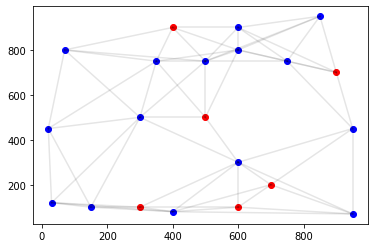

In [204]:
N = list(coordinates.keys())
L = set()
for u in N:
    # from each note, we only consider edges to the closest 5 other nodes
    lst = sorted([(dist(u, v), v) for v in N if v != u])[:5]
    for _, v in lst:
        L.add((min(u, v), max(u, v)))
L = list(L)
draw_network(L, coordinates, demsup)
cost = {(u, v): dist(u, v) for (u, v) in L}

## Model for single-node failure


We consider a simplified network (i.e., we ignore the existence of transformers near the cities among other components). Let $E$ be the set of edges (i.e., undirected), and $A$ be the set of (directed) arcs connecting each pair $i,j$.
The parameters of this model are the
arc capacities $U_{ij}=1000$ (Megawatts), nodes production or
consumption $b_i$ (negative value means that there is energy production in the node), and the cost of each line $c_{ij}$, equal to one
million euro per kilometer of the edge $(i,j)$.

We define the following variables:
- $y_{ij}$ is 1 if edge $\{i,j\}$ is constructed, 0 otherwise;
- $f_{ij}$ is the flow on arc $(i,j)$ if there is no failure on any other arc;
- $f_{ij}^{u}$ is the flow on edge $\{i,j\}$ if there is a failure on node $u$;

The objective is to minimize total cost of connecting the nodes:

$$\textrm{minimize } \sum_{\{i,j\} \in E} c_{ij} y_{ij}$$

The restrictions are the following:
- There can only be flow if the edge was built:

$$f_{ij} \leq U_{ij} y_{ij}, \;\;\; \forall \{i,j\} \in E$$
$$f_{ji} \leq U_{ji} y_{ij}, \;\;\; \forall \{i,j\} \in E$$

- Demand and production capacity satisfaction:

$$\sum_{(i,j) \in A} f_{ij} - \sum_{(j,i) \in A} f_{ji} \geq b_i,
\;\;\; \forall i \in N$$

- There cannot be flow through node $u$ when it fails:

$$\sum_{(i,u) \in A} f_{iu}^u + \sum_{(u,j) \in A} f_{uj}^u = 0, \;\;\; \forall u \in N$$

- If node $u$ fails, flow through remaining edges and satisfy demand:

$$\sum_{(i,j) \in A} f_{ij}^u - \sum_{(j,i) \in A} f_{ji}^u \geq b_i,
\;\;\; \forall u \in N, \forall i \in N \setminus \{u\}$$

- Arcs needed when node $u$ fails must be built:

$$f_{ij}^u \leq U_{ij} y_{ij}, \;\;\; \forall \{i,j\} \in E$$
$$f_{ji}^u \leq U_{ji} y_{ij}, \;\;\; \forall \{i,j\} \in E$$


In [205]:
%%ampl_eval
set N;                                     # nodes
set L within N cross N;                    # set of links
set A = L union setof {(i,j) in L} (j,i);  # arcs (directed)

param demsup{N};   # demand (positive) or supply (negative)
param cost{L};     # cost to build a link
param capacity;    # capacity of links

var Build {L} binary;   # Build[i,j] = 1 iff link btw i & j is built
var Flow {A} >= 0;      # Flow[i,j] is flow from i to j

minimize TotalBuildCost:
    sum {(i,j) in L} cost[i,j] * Build[i,j];

subject to Balance {i in N}:
    sum {(j,i) in A} Flow[j,i] - sum{(i,j) in A} Flow[i,j] >= demsup[i];

subject to ArcExists1 {(i,j) in L}:
    Flow[i,j] <= Build[i,j] * capacity;
subject to ArcExists2 {(i,j) in L}:
    Flow[j,i] <= Build[i,j] * capacity;

var FlRm {A,N} >= 0; # FlRm[i,j,rn] is flow from i to j when node rn is removed

subject to RemoveNode {rm in N}:
    sum {(i,rm) in A} FlRm[i,rm,rm] + sum {(rm,j) in A} FlRm[rm,j,rm] = 0;

subject to BalanceRm {i in N, rm in N: i != rm}:
    sum {(j,i) in A} FlRm[j,i,rm] - sum {(i,j) in A} FlRm[i,j,rm] >= demsup[i];

subject to ArcExistsRm1 {(i,j) in L, rm in N}:
    FlRm[i,j,rm] <= Build[i,j] * capacity;
subject to ArcExistsRm2 {(i,j) in L, rm in N}:
    FlRm[j,i,rm] <= Build[i,j] * capacity;

## Load data

In [206]:
ampl.set["N"] = N
ampl.set["L"] = L
ampl.param["capacity"] = capacity
ampl.param["cost"] = cost
ampl.param["demsup"] = demsup

In [207]:
ampl.param["demsup"].to_pandas()

,demsup
1.0,-900.0
2.0,-500.0
3.0,-1200.0
4.0,-450.0
5.0,-750.0
6.0,-1200.0
7.0,200.0
8.0,300.0
9.0,200.0
10.0,250.0


## Solve

In [208]:
ampl.option["solver"] = "gurobi"
ampl.option["gurobi_options"] = "outlev=1 timelim=10"
ampl.option["highs_options"] = "outlev=1 timelim=60"
ampl.solve()

Gurobi 10.0.0: Set parameter OutputFlag to value 1
tech:outlev=1
Set parameter TimeLimit to value 10
lim:time=10
Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 2921 rows, 2542 columns and 9920 nonzeros
Model fingerprint: 0x250da436
Variable types: 2480 continuous, 62 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+03]

User MIP start did not produce a new incumbent solution
User MIP start violates constraint R2486 by 200.000000000

Found heuristic solution: objective 16794.262944
Presolve time: 0.01s
Presolved: 2921 rows, 2542 columns, 9920 nonzeros
Variable types: 2480 continuous, 62 integer (62 binary)

Root relaxation: objective 1.807099e

## Display solution

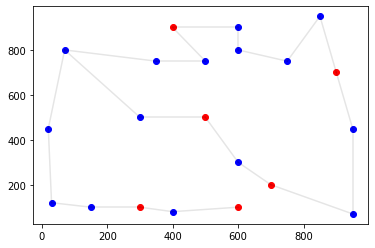

In [209]:
d = ampl.get_data("{(i,j) in L: Build[i,j] > 0} Build[i,j]").to_dict()
draw_network(d.keys(), coordinates, demsup)

## Display flows

In [210]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_solution(flow, title):
    solution = {}
    edges = set(((min(u, v)), max(u, v)) for u, v in flow)
    for u, v in edges:
        f = flow.get((u, v), 0) - flow.get((v, u), 0)
        u, v = int(u), int(v)
        if abs(f) == 0:
            solution[(u, v)] = solution[(v, u)] = 0
        else:
            solution[(u, v) if f > 0 else (v, u)] = abs(f)
    G = nx.DiGraph()
    color_map = []
    for u in coordinates:
        G.add_node(u, pos=coordinates[u])
        color_map.append("red" if demsup[u] < 0 else "blue")
    G.add_edges_from(solution.keys())
    pos = nx.get_node_attributes(G, "pos")
    f = plt.figure(figsize=(10, 8), dpi=75)
    ax = f.add_subplot()
    ax.set_title(title)
    nx.draw(G, pos, with_labels=True, ax=ax, node_color=color_map)
    labels = nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels={(u, v): f"{f:.0f}" for (u, v), f in solution.items() if f > 0},
    )
    labels = nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels={(u, v): "0" for (u, v), f in solution.items() if f <= 0},
        font_color="red",
    )

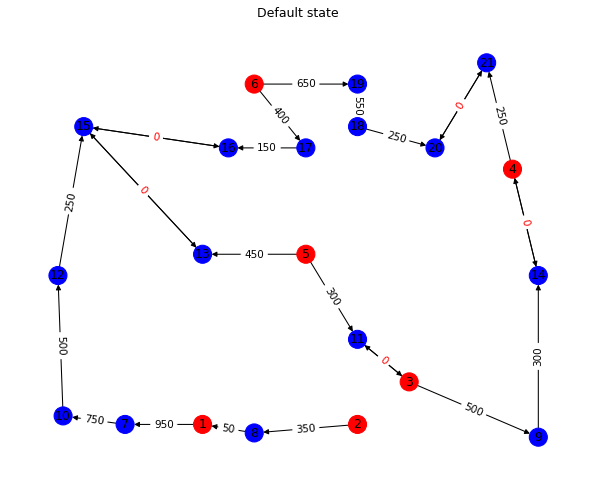

In [211]:
draw_solution(
    ampl.get_data("{(i,j) in A: Build[min(i,j),max(i,j)] > 0} Flow[i,j]").to_dict(),
    "Default state",
)

## During failures

<ipython-input-210-9a40522e9a71>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(10, 8), dpi=75)


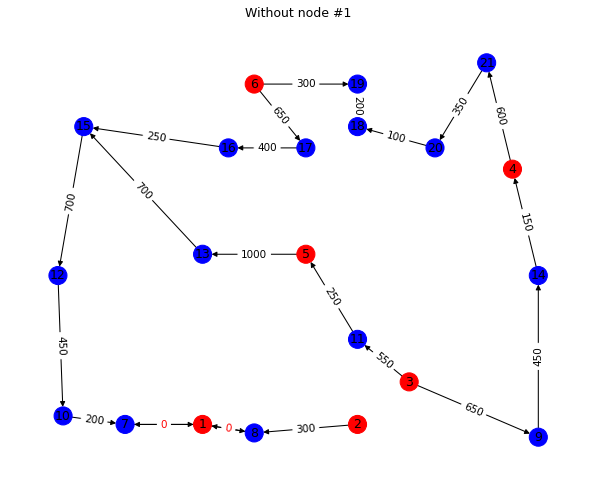

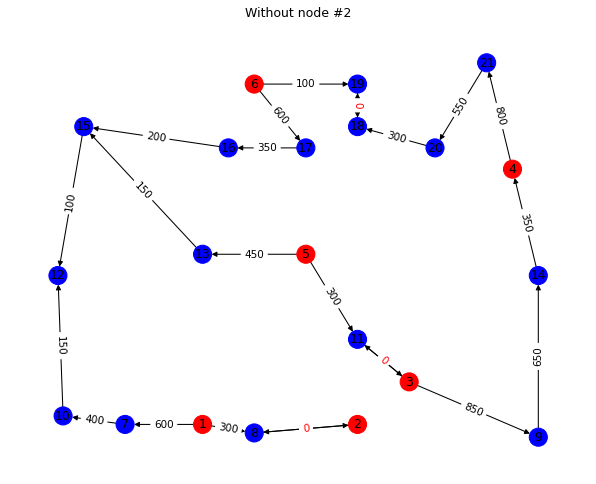

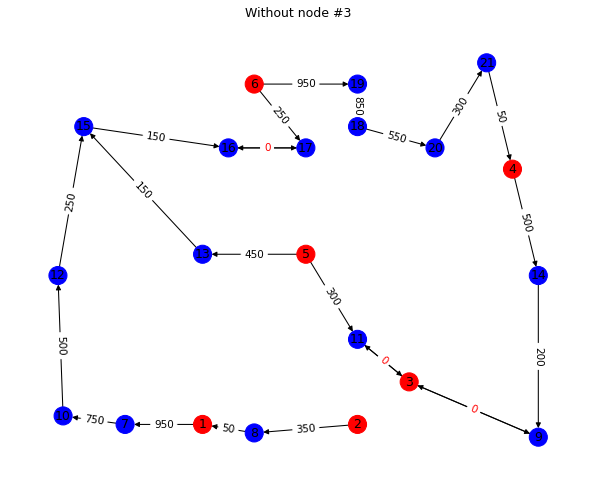

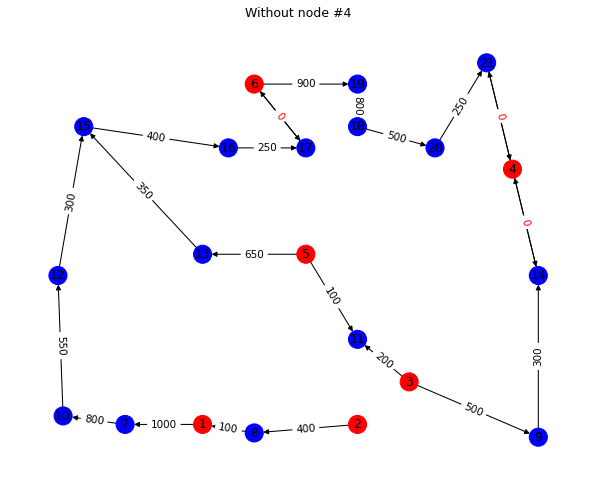

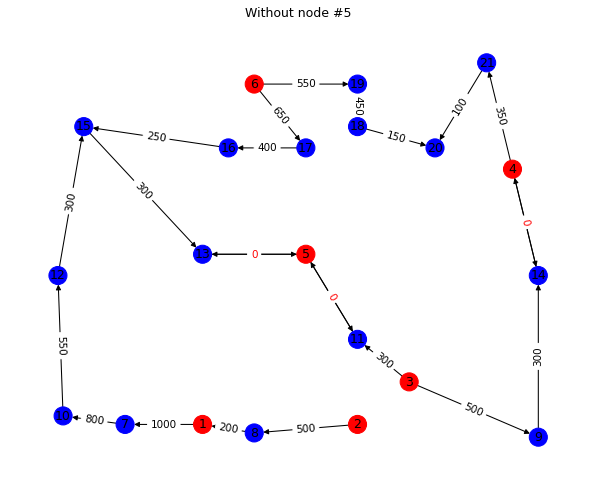

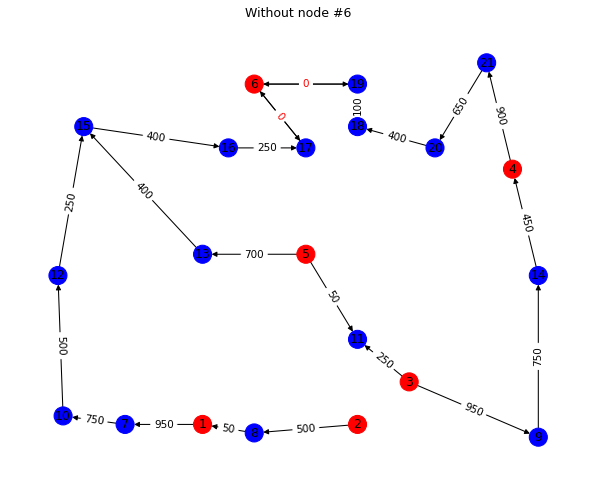

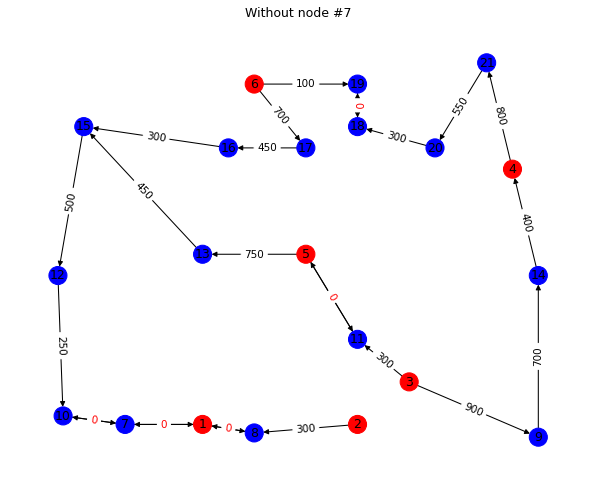

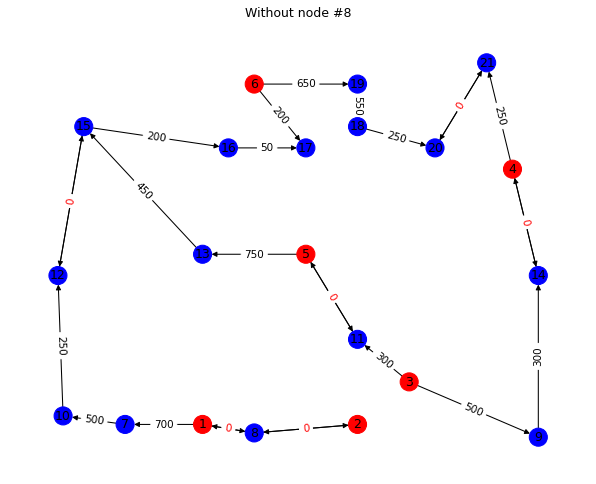

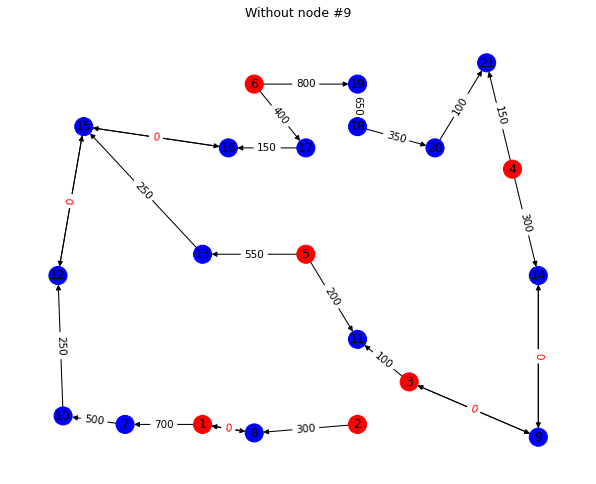

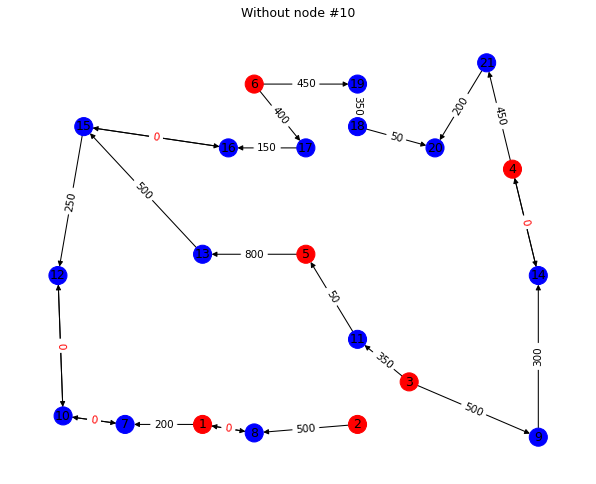

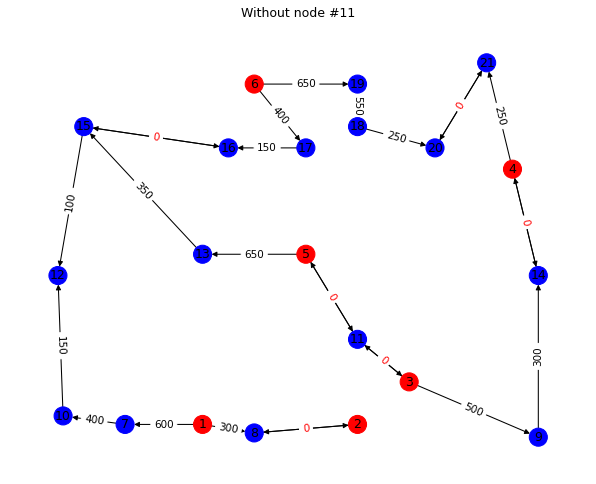

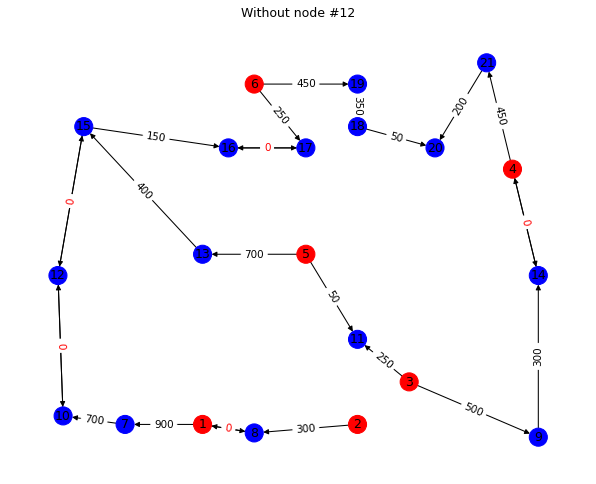

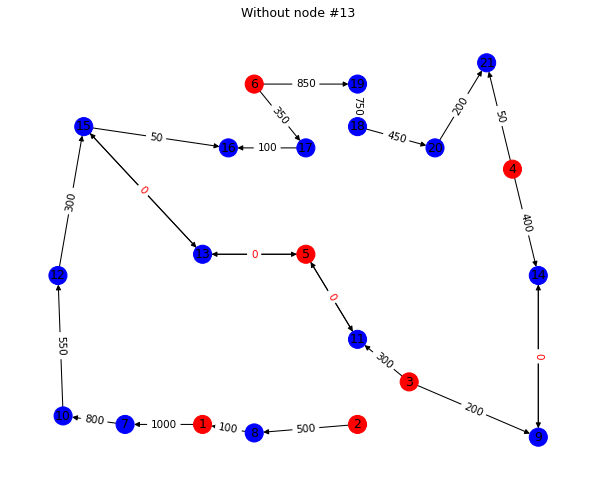

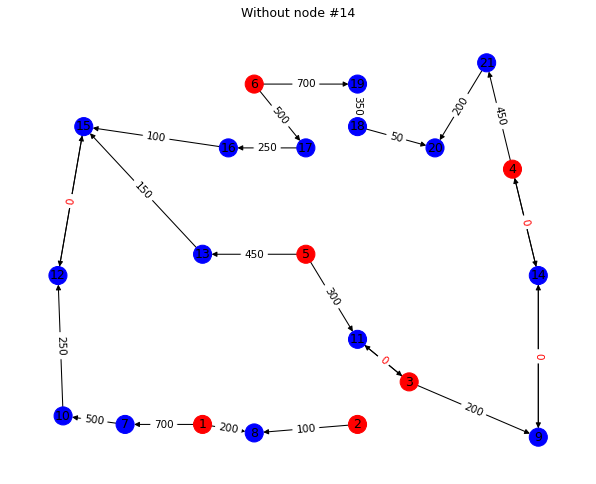

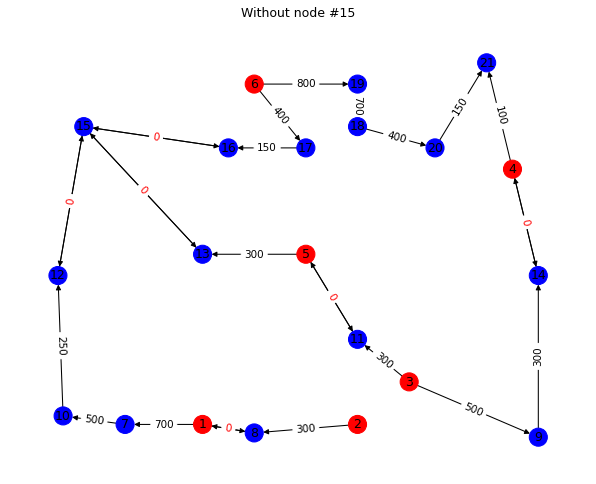

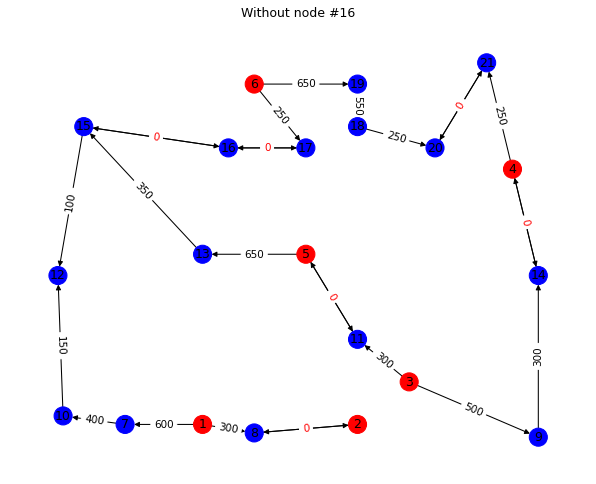

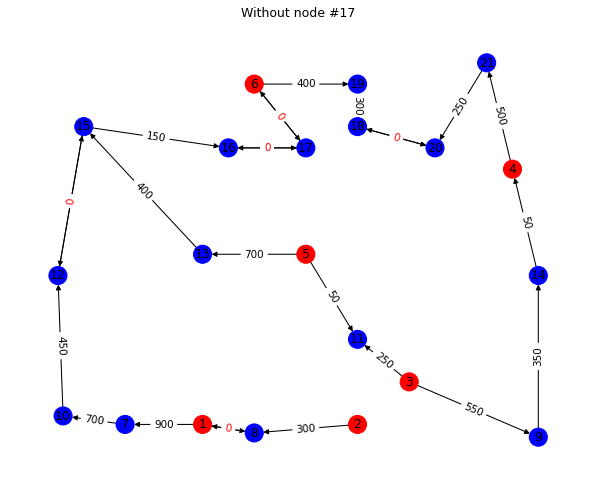

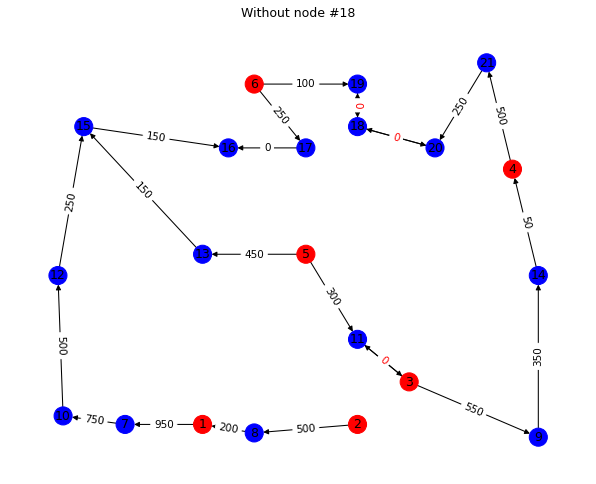

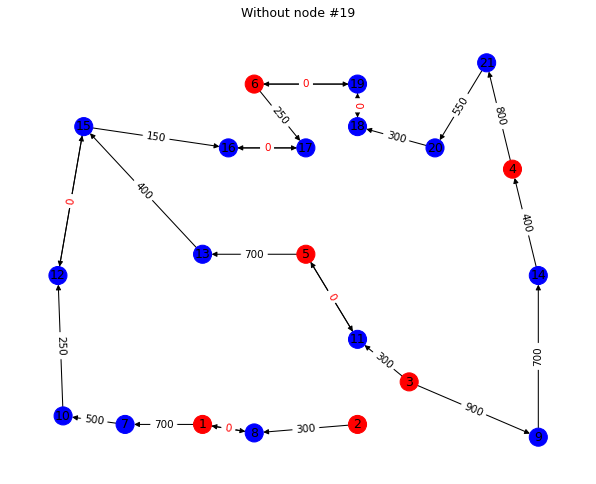

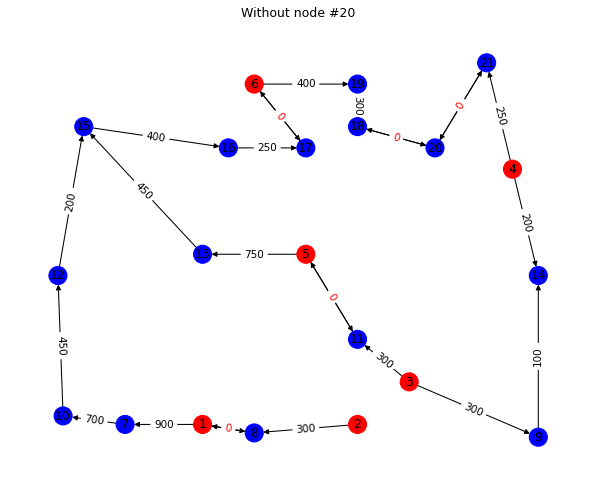

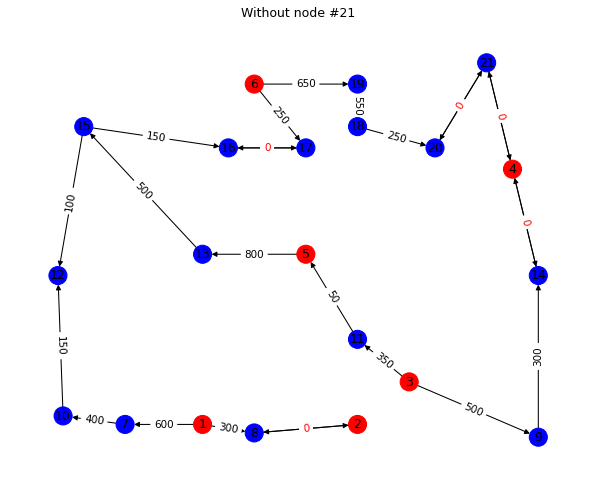

In [212]:
for u in N:
    draw_solution(
        ampl.get_data(
            "{(i,j) in A: Build[min(i,j),max(i,j)] > 0}" + f"FlRm[i,j,{u}]"
        ).to_dict(),
        title=f"Without node #{u}",
    )

## Model for double-node failure

We define the following variables:
- $y_{ij}$ is 1 if edge $\{i,j\}$ is constructed, 0 otherwise;
- $f_{ij}$ is the flow on arc $(i,j)$ if there is no failure on any other arc;
- $f_{ij}^{uv}$ is the flow on edge $\{i,j\}$ if both nodes $u$ and $v$ fail;

The objective is to minimize total cost of connecting the nodes:

$$\textrm{minimize } \sum_{\{i,j\} \in E} c_{ij} y_{ij}$$

The restrictions are the following:
- There can only be flow if the edge was built:

$$f_{ij} \leq U_{ij} y_{ij}, \;\;\; \forall \{i,j\} \in E$$
$$f_{ji} \leq U_{ji} y_{ij}, \;\;\; \forall \{i,j\} \in E$$

- Demand and production capacity satisfaction:

$$\sum_{(i,j) \in A} f_{ij} - \sum_{(j,i) \in A} f_{ji} \geq b_i,
\;\;\; \forall i \in N$$

- There cannot be flow through nodes $u$ and $v$ when they fail:

$$\sum_{(i,u) \in A} f_{iu}^{uv} + \sum_{(u,j) \in A} f_{uj}^{uv} + \sum_{(i,v) \in A} f_{iv}^{uv} + \sum_{(v,j) \in A} f_{vj}^{uv} = 0, \;\;\; \forall (u,v) \in N \times N$$

- If nodes $u$ and $v$ fail, flow through remaining edges and satisfy demand:

$$\sum_{(i,j) \in A} f_{ij}^{uv} - \sum_{(j,i) \in A} f_{ji}^{uv} \geq b_i,
\;\;\; \forall (u,v) \in N \times N, \forall i \in N \setminus \{u,v\}$$

- Arcs needed when node $u$ fails must be built:

$$f_{ij}^{uv} \leq U_{ij} y_{ij}, \;\;\; \forall (u,v) \in N \times N, \forall \{i,j\} \in E$$
$$f_{ji}^{uv} \leq U_{ji} y_{ij}, \;\;\; \forall (u,v) \in N \times N, \forall \{i,j\} \in E$$


In [213]:
%%ampl_eval
reset;
set N;                                     # nodes
set L within N cross N;                    # set of links
set A = L union setof {(i,j) in L} (j,i);  # arcs (directed)

param demsup{N};   # demand (positive) or supply (negative)
param cost{L};     # cost to build a link
param capacity;    # capacity of links

var Build {L} binary;   # Build[i,j] = 1 iff link btw i & j is built
var Flow {A} >= 0;      # Flow[i,j] is flow from i to j

minimize TotalBuildCost:
    sum {(i,j) in L} cost[i,j] * Build[i,j];

subject to Balance {i in N}:
    sum {(j,i) in A} Flow[j,i] - sum{(i,j) in A} Flow[i,j] >= demsup[i];

subject to ArcExists1 {(i,j) in L}:
    Flow[i,j] <= Build[i,j] * capacity;
subject to ArcExists2 {(i,j) in L}:
    Flow[j,i] <= Build[i,j] * capacity;

set RNs := {rn1 in N, rn2 in N : rn1 < rn2}; # pairs or nodes that may fail

var frns{A, RNs} >= 0;
s.t. RemoveNodes{(rn1,rn2) in RNs}:
    sum{(i1,rn1) in A} frns[i1,rn1,rn1,rn2] + sum{(rn1,j1) in A} frns[rn1,j1,rn1,rn2]
    + sum{(i2,rn2) in A} frns[i2,rn2,rn1,rn2] + sum{(rn2,j2) in A} frns[rn2,j2,rn1,rn2] = 0;
s.t. BalanceRN{u in N, (rn1,rn2) in RNs: u != rn1 && u != rn2}:
    sum{(i,u) in A} frns[i,u,rn1,rn2] - sum{(u,j) in A} frns[u,j,rn1,rn2] >= demsup[u];
s.t. ArcExistsRN1{(i,j) in L, (rn1,rn2) in RNs}:
    frns[i,j,rn1,rn2] <= Build[i,j] * capacity;
s.t. ArcExistsRN2{(i,j) in L, (rn1,rn2) in RNs}:
    frns[j,i,rn1,rn2] <= Build[i,j] * capacity;

In [214]:
ampl.set["N"] = N
ampl.set["L"] = L
ampl.param["cost"] = cost
ampl.param["capacity"] = capacity
# The power production has to be higher in order to have feasible solutions if two power stations fail
demsup = {
    1: -1900,
    2: -1500,
    3: -2200,
    4: -1450,
    5: -1750,
    6: -2200,
    7: 200,
    8: 300,
    9: 200,
    10: 250,
    11: 300,
    12: 250,
    13: 300,
    14: 300,
    15: 250,
    16: 150,
    17: 250,
    18: 300,
    19: 100,
    20: 250,
    21: 250,
}
ampl.param["demsup"] = demsup

In [215]:
ampl.option["solver"] = "gurobi"
ampl.option["gurobi_options"] = "outlev=1 timelim=60"
ampl.option["highs_options"] = "outlev=1 timelim=60"
ampl.solve()

Gurobi 10.0.0: Set parameter OutputFlag to value 1
tech:outlev=1
Set parameter TimeLimit to value 60
lim:time=60
Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 25339 rows, 21390 columns and 85312 nonzeros
Model fingerprint: 0xd5811b0f
Variable types: 21328 continuous, 62 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 2e+03]

User MIP start did not produce a new incumbent solution
User MIP start violates constraint R21334 by 200.000000000

Found heuristic solution: objective 16902.932489
Presolve removed 75 rows and 73 columns
Presolve time: 0.14s
Presolved: 25264 rows, 21317 columns, 85046 nonzeros
Variable types: 21255 continuous, 62 integer 

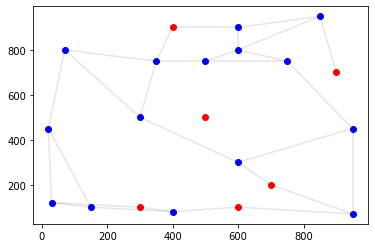

In [216]:
d = ampl.get_data("{(i,j) in L: Build[i,j] > 0} Build[i,j]").to_dict()
draw_network(d.keys(), coordinates, demsup)

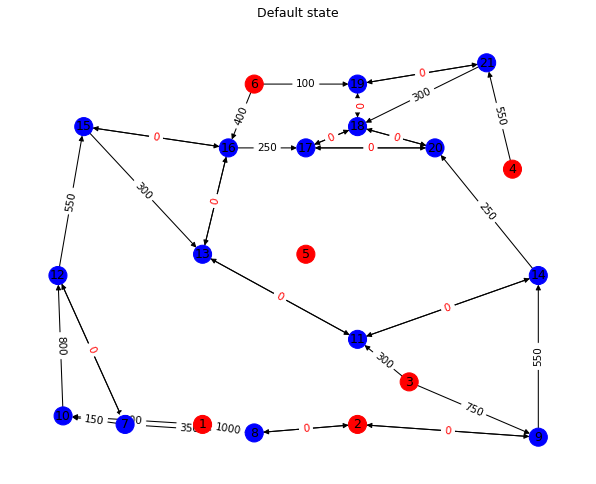

In [217]:
draw_solution(
    ampl.get_data("{(i,j) in A: Build[min(i,j),max(i,j)] > 0} Flow[i,j]").to_dict(),
    "Default state",
)

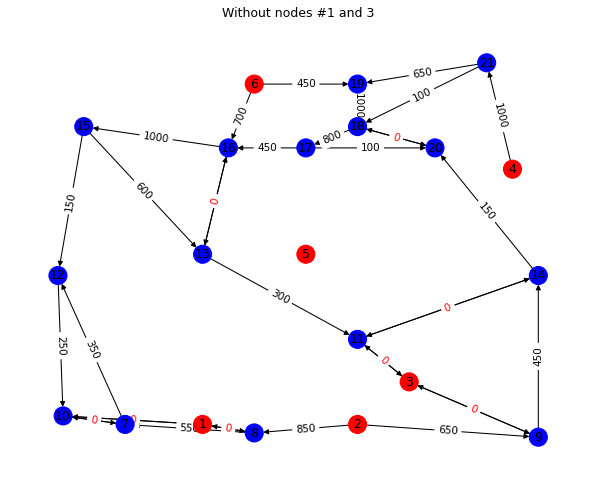

In [218]:
u, v = 1, 3
draw_solution(
    ampl.get_data(
        "{(i,j) in A: Build[min(i,j),max(i,j)] > 0}" + f"frns[i,j,{u},{v}]"
    ).to_dict(),
    title=f"Without nodes #{u} and {v}",
)